<a href="https://colab.research.google.com/github/perskine/githubtesttwo/blob/master/HousePriceModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will be used to build a model to predict the price of a house given other variables

# Setup the libraries

In [1]:
# setup the libraries for the analysis

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import xgboost as xgb
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Read the Data

In [2]:
# Read in the dataset

df = pd.read_csv('/content/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Exploration and Preprocessing

* Use the following columns for as input variables: columns = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms', 'view','sqft_basement',
'lat','waterfront','yr_built','bedrooms']

* Use price as target variable

In [3]:
# define input varibales

columns = ['sqft_living','grade', 'sqft_above', 'sqft_living15',
           'bathrooms','view','sqft_basement','lat','long','waterfront',
           'yr_built','bedrooms']

# The target Variable price

* Analyse the distribution of our target variable



In [4]:
# Find the max and min price

print(f'lowest price: {np.min(df["price"])}, highest price: {np.max(df["price"])}')

lowest price: 75000.0, highest price: 7700000.0


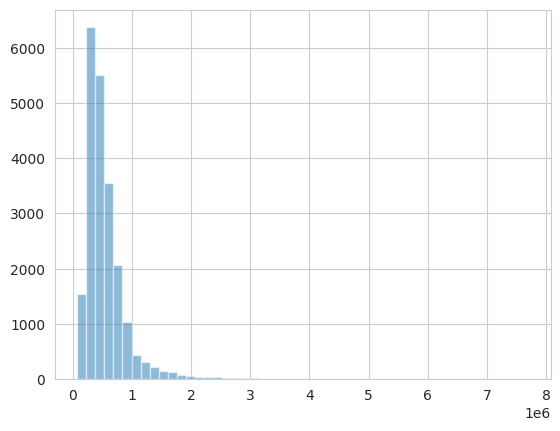

In [5]:
# Plot the histogram for the dataset

frequency, bins = np.histogram(df['price'], bins=50, range=[np.min(df['price']), np.max(df['price'])])
plt.hist(df['price'], alpha=0.5, bins=bins, label='true');

* The price is not normally distributed, there are a few houses, which are very expensive.
* Use log of the price to normalize the distribution.

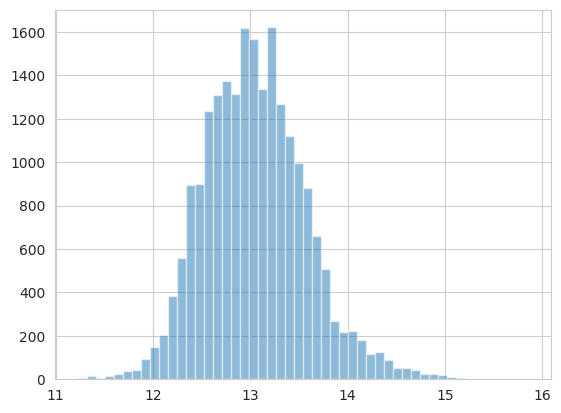

In [6]:
## Plot the Histogram of the price

frequency, bins = np.histogram(np.log1p(df['price']), bins=50, range=[np.min(np.log1p(df['price'])), np.max(np.log1p(df['price']))])
plt.hist(np.log1p(df['price']), alpha=0.5, bins=bins, label='true');

* Now the distribution is more normally, we will use the log-transformation of the price as our target variable

# The Input Data
Analyse the input varibales

In [7]:
# Find the number of columns

print(f'Number of input columns: {len(columns)}')

Number of input columns: 12


* A general overview of the dataframe:
* How many entries do we have?
* Which type are the varibales?
* Are there missing values?

In [8]:
# Check the info about the dataset

df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_above     21613 non-null  int64  
 3   sqft_living15  21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   view           21613 non-null  int64  
 6   sqft_basement  21613 non-null  int64  
 7   lat            21613 non-null  float64
 8   long           21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  yr_built       21613 non-null  int64  
 11  bedrooms       21613 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 2.0 MB


* There are no mising values in the data
* Now, plot the distributions of the input varibales

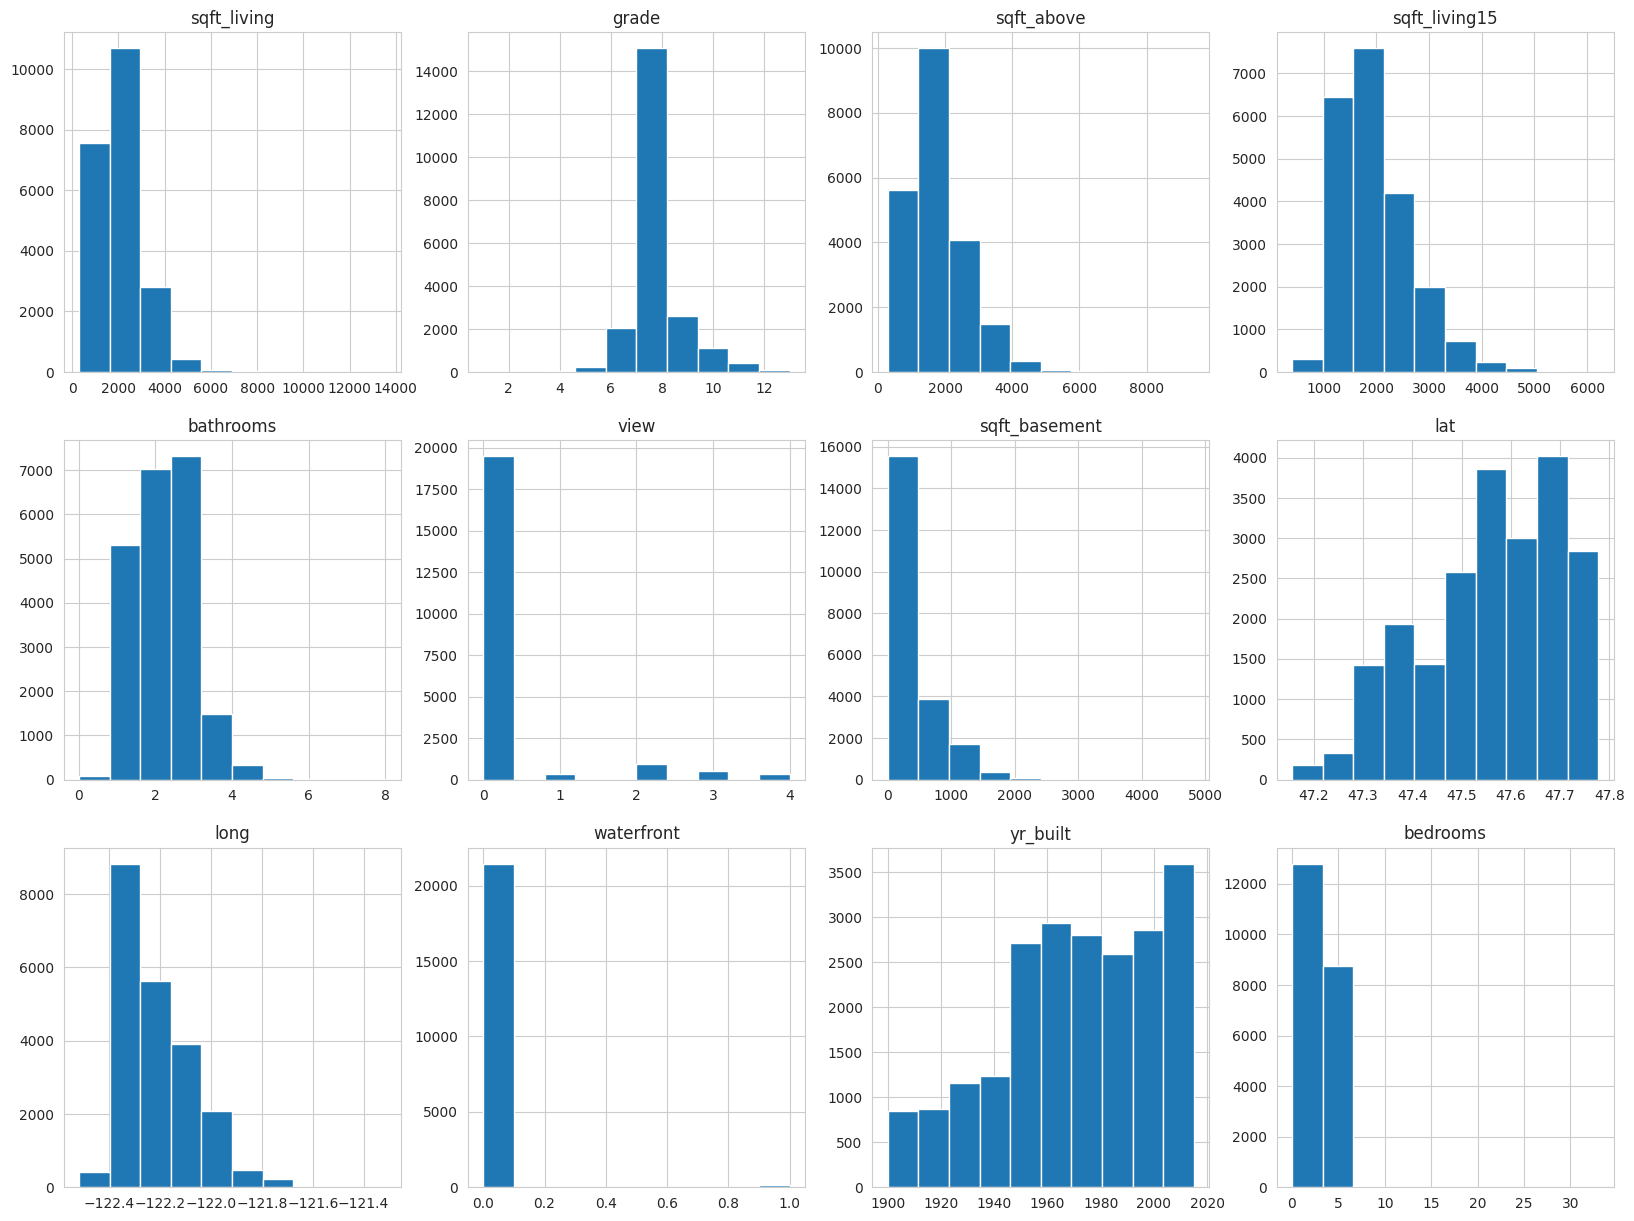

In [9]:
# plot a histogram of all the independent variables

fig, axis = plt.subplots(3, 4, figsize=(20,15))
for i, ax in enumerate(axis.flat):
    ax.hist(df[columns[i]])
    ax.set_title(columns[i])

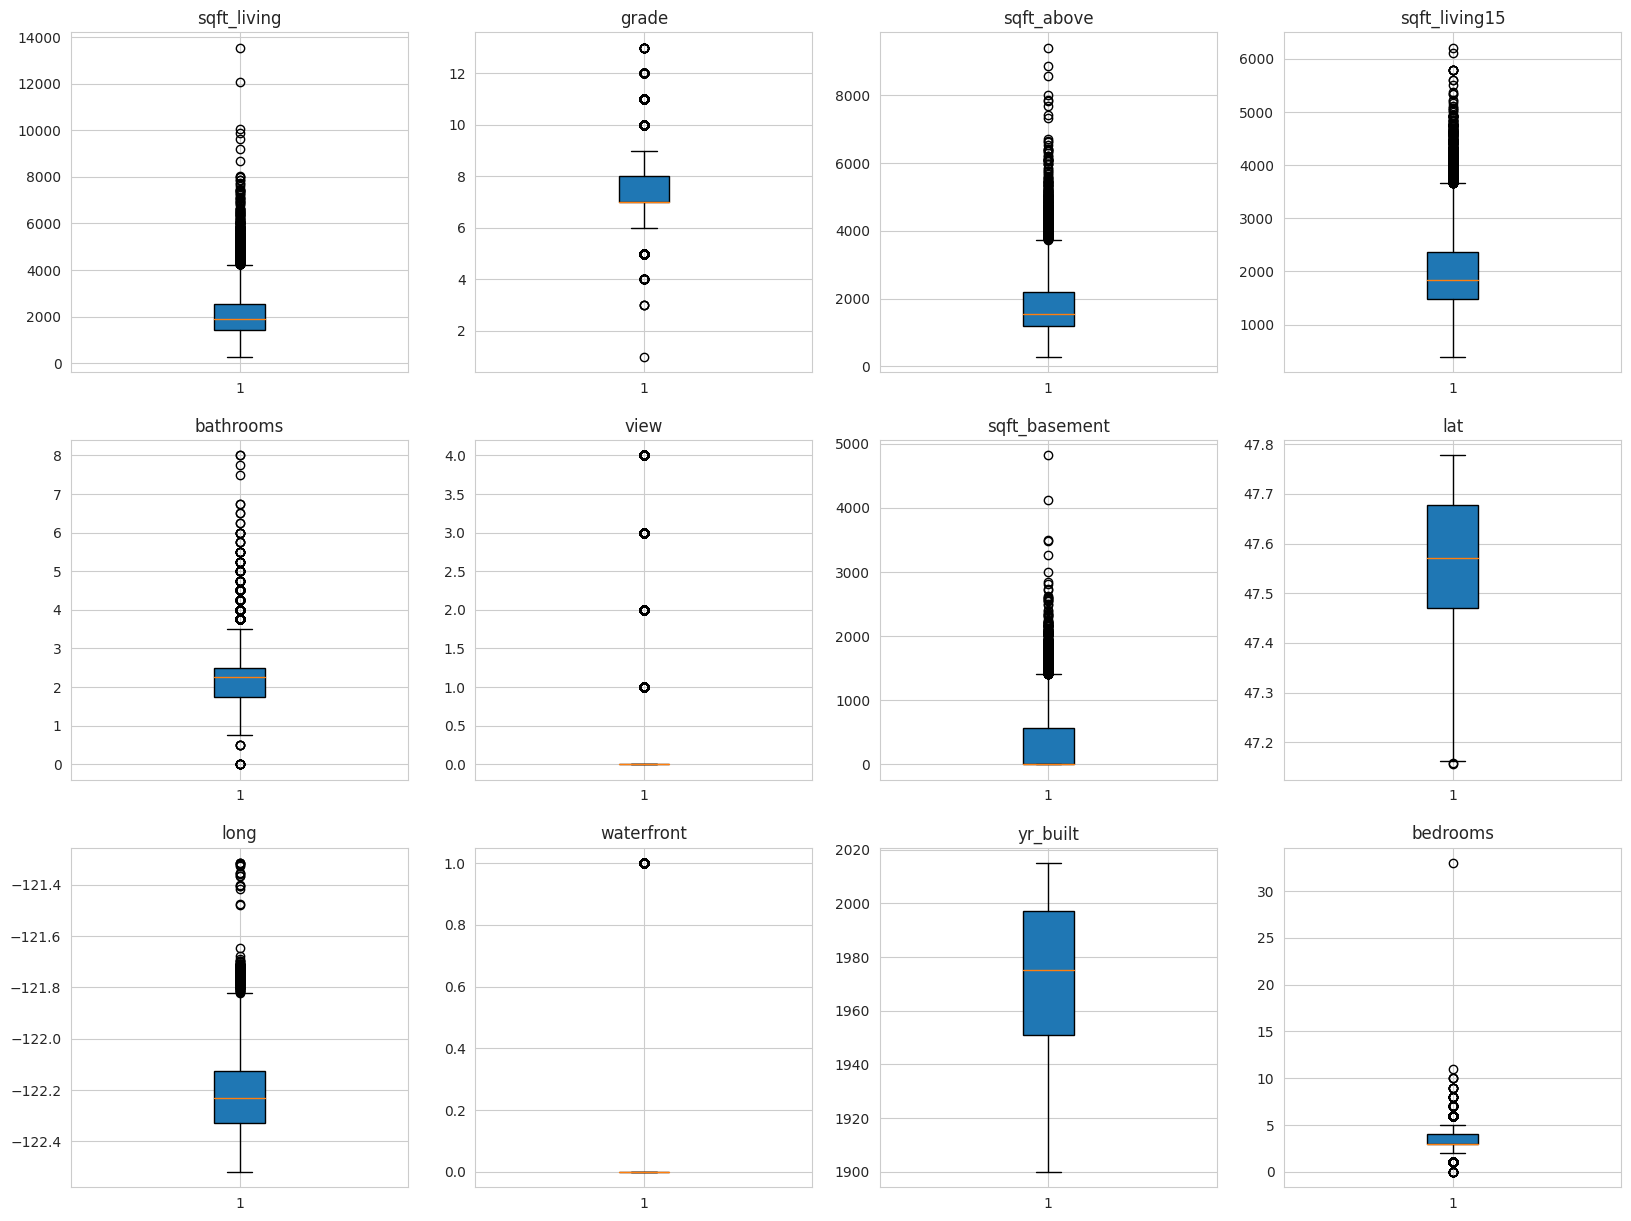

In [10]:

# Plot the graph of the boxplot

fig, axis = plt.subplots(3, 4, figsize=(20,15))
for i, ax in enumerate(axis.flat):
    ax.boxplot(df[columns[i]], patch_artist=True)
    ax.set_title(columns[i])

* We see that grade, view and waterfront are categorical variables.
* Bedrooms has an outlier. We will delete this entry.

In [11]:
# Check the unique variables

df["bedrooms"].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [12]:
# Delete entry with 33 bedrooms

df = df[df["bedrooms"] != 33]
df["bedrooms"].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10])

* Since grade, view and waterfront are categorical variable, we change their type to object

In [13]:
# Convert the variable type to object

df[['grade','view','waterfront']] = df[['grade','view','waterfront']].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21612 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21612 non-null  int64  
 1   date           21612 non-null  object 
 2   price          21612 non-null  float64
 3   bedrooms       21612 non-null  int64  
 4   bathrooms      21612 non-null  float64
 5   sqft_living    21612 non-null  int64  
 6   sqft_lot       21612 non-null  int64  
 7   floors         21612 non-null  float64
 8   waterfront     21612 non-null  object 
 9   view           21612 non-null  object 
 10  condition      21612 non-null  int64  
 11  grade          21612 non-null  object 
 12  sqft_above     21612 non-null  int64  
 13  sqft_basement  21612 non-null  int64  
 14  yr_built       21612 non-null  int64  
 15  yr_renovated   21612 non-null  int64  
 16  zipcode        21612 non-null  int64  
 17  lat            21612 non-null  float64
 18  long  

<ipython-input-13-08143e90e632>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['grade','view','waterfront']] = df[['grade','view','waterfront']].astype('object')


In [14]:
# train - validation split

X_train_full, X_test, y_train_full, y_test = train_test_split(df[columns], df['price'], test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=True, random_state=42)
print(f'train data shape: X - {X_train.shape}, y - {y_train.shape}')
print(f'validation data shape: X - {X_val.shape}, y - {y_val.shape}')
print(f'test data shape: X - {X_test.shape}, y - {y_test.shape}')

train data shape: X - (12966, 12), y - (12966,)
validation data shape: X - (4323, 12), y - (4323,)
test data shape: X - (4323, 12), y - (4323,)


* convert target to logarithmic and plot training and validation distribution

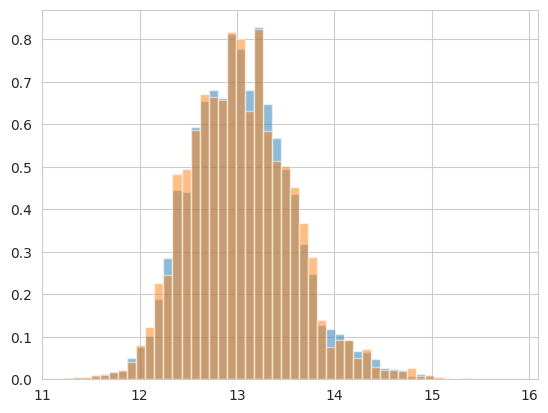

In [15]:
# Plot Histogram of the log of the price

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
frequency, bins = np.histogram(y_train, bins=50, range=[np.min(y_train), np.max(y_train)])
plt.hist(y_train, alpha=0.5, bins=bins, density='true');
plt.hist(y_val, alpha=0.5, bins=bins, density='true');

* Make cateorical variables one-hot encoded

In [16]:
# define categorical and numerical varibales

categorical = ['grade', 'view', 'waterfront']

numerical = ['sqft_living', 'sqft_above', 'sqft_living15',
           'bathrooms','sqft_basement','lat','long',
           'yr_built','bedrooms']

In [17]:
# Intansite the one hot encoder

ohe = OneHotEncoder()
X_train_cat = ohe.fit_transform(X_train[categorical]).toarray()
X_val_cat = ohe.transform(X_val[categorical]).toarray()

In [18]:
# Convert the numerical variables

X_train_num = np.array(X_train[numerical])
X_val_num = np.array(X_val[numerical])

* Define final training and validation input varibales


In [19]:
# Put the categorical and numerical dataset together

X_train = np.concatenate([X_train_cat, X_train_num], axis=1)
X_val = np.concatenate([X_val_cat, X_val_num], axis=1)
print(f'X_train shape: {X_train.shape}, X_val shape {X_val.shape}')

X_train shape: (12966, 28), X_val shape (4323, 28)


# Modeling
* Set up a XGBoost Regressor and fit it to the training data

In [20]:
# Initialize XGB with rmse as objective

parameters = {"objective" : 'reg:squarederror',
              "n_estimators" :100,
              "eta" : 0.3,
              "max_depth" : None,
              "min_child_weight" : 1,
              "verbosity" : 1}

model = xgb.XGBRFRegressor(**parameters)
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False, eta=0.3,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None, ...)

* Make predictions on training and validation set to compare the performance of the model on both datasets

In [21]:
# generate predictions

y_pred_train = model.predict(X_train).reshape(-1,1)
y_pred = model.predict(X_val).reshape(-1,1)

# calculate errors

rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
rmse_val = mean_squared_error(y_pred, y_val, squared=False)
print(f"rmse training: {rmse_train:.3f}\t rmse validation: {rmse_val:.3f}")

rmse training: 0.215	 rmse validation: 0.227


* Plot predictions versus true values

In [22]:
# setup the y_train and y_val dataset

y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

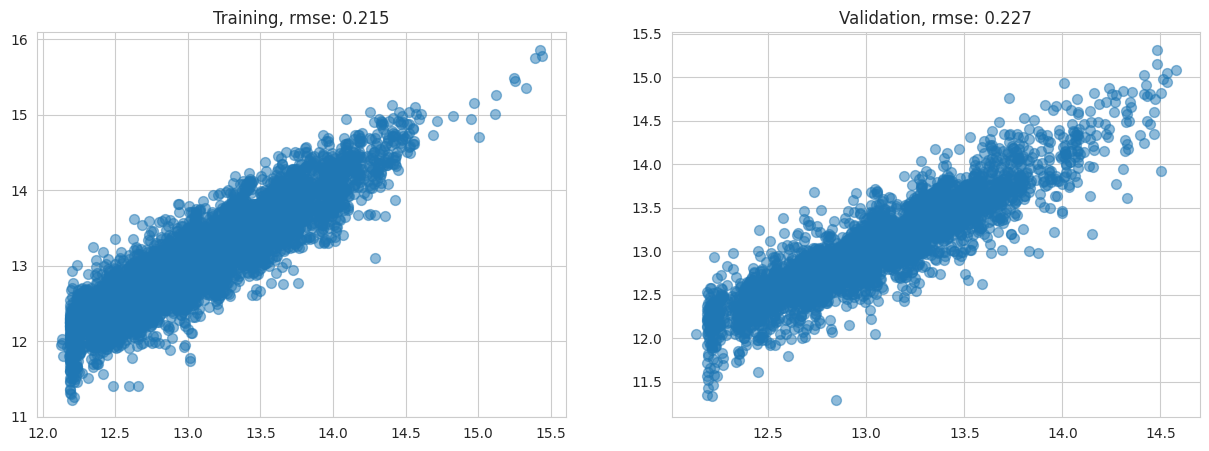

In [23]:
# plot the training and validation

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(y_pred_train, y_train, alpha=0.5, s=50)
axes[0].set_title(f"Training, rmse: {rmse_train:.3f}")
axes[1].scatter(y_pred, y_val, alpha=0.5, s=50)
axes[1].set_title(f"Validation, rmse: {rmse_val:.3f}")  ;

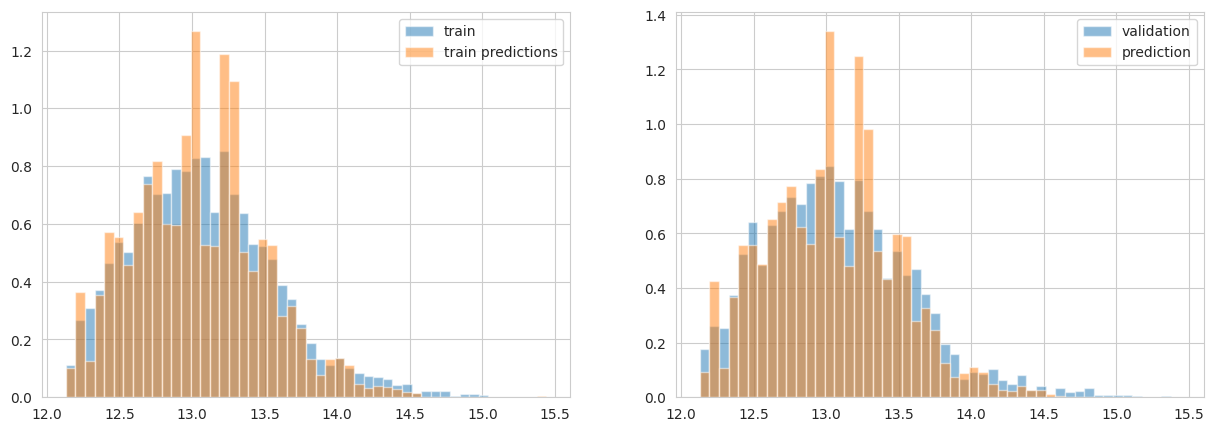

In [24]:
# Plot the histogram and training and validation dataset

fig, axes = plt.subplots(1, 2, figsize=(15,5))
frequency, bins = np.histogram(y_train, bins=50, range=[np.min(y_pred_train), np.max(y_pred_train)])
axes[0].hist(y_train, alpha=0.5, bins=bins, density='true', label="train")
axes[0].hist(y_pred_train, alpha=0.5, bins=bins, density='true', label="train predictions")
axes[0].legend()
axes[1].hist(y_val, alpha=0.5, bins=bins, density='true', label="validation")
axes[1].hist(y_pred, alpha=0.5, bins=bins, density='true', label="prediction")
axes[1].legend();

* The predictions on the validation set have a slightly higher error, but overall compare well to the predictions on the training set. Both distributions look similar. This is a good indicator, that the model can generate well

# Make Predictions

* Now make predictions on the test set
* First make the same preprocessing steps on the test set

In [25]:
# setup the categorical and numerical dataset

X_test_cat = ohe.transform(X_test[categorical]).toarray()
X_test_num = np.array(X_test[numerical])
X_test = np.concatenate([X_test_cat, X_test_num], axis=1)

* Make predictions

In [26]:
# Use the model the predict test set

y_pred_test = model.predict(X_test).reshape(-1,1)

* Reconvert predictions using np.exp1m

In [27]:
# Convert the predicted values to a general value by de log the values

y_pred_test = np.expm1(y_pred_test)

* Plot scatterplot and distributions compared to test data

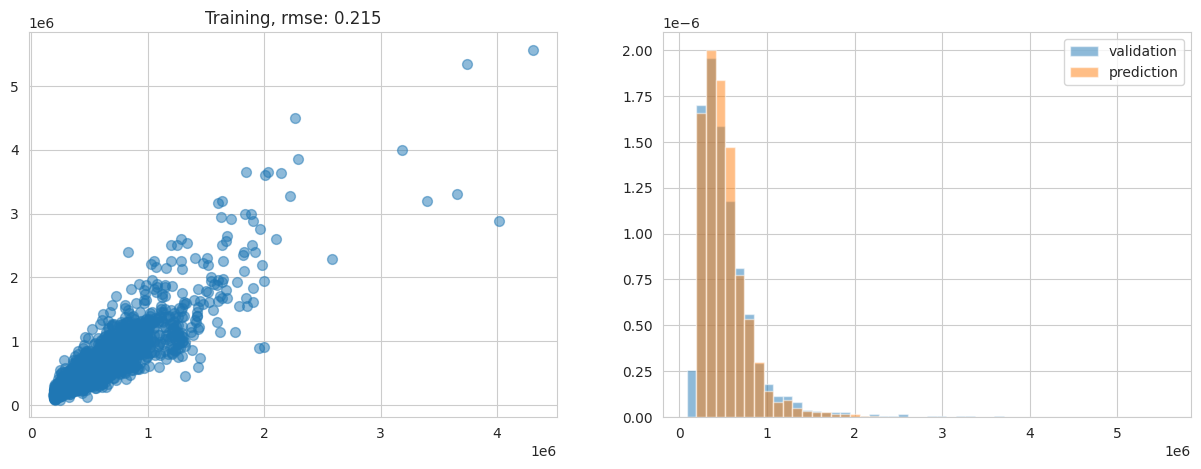

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(y_pred_test, y_test, alpha=0.5, s=50)
axes[0].set_title(f"Training, rmse: {rmse_train:.3f}")
frequency, bins = np.histogram(y_test, bins=50, range=[np.min(y_test), np.max(y_test)])
axes[1].hist(y_test, alpha=0.5, bins=bins, density='true', label="validation")
axes[1].hist(y_pred_test, alpha=0.5, bins=bins, density='true', label="prediction")
axes[1].legend();